In [86]:
# Analysis libraries
import numpy as np
import pandas as pd
from scipy.stats import entropy, norm, gamma, linregress, pearsonr
from scipy.optimize import curve_fit
from scipy.special import gamma, hyp2f1
from scipy.stats import ks_2samp, kstest
from scipy.spatial.distance import pdist
from scipy.stats import entropy

from math import inf

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.ticker as tck
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import shapely 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LogNorm, SymLogNorm

# Other libraries
import os
import sys
import re
import itertools
from tqdm import tqdm
import pickle


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
sys.path.append('../scripts')
from utils import *
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
from scipy.special import zeta

class Zipf:
    def __init__(self, alpha):
        self.alpha = alpha

# Helper function for generalized harmonic numbers
def harmonic(n, alpha):
    return sum(1 / (k ** alpha) for k in range(1, n + 1))

# Calculate the normalization constant (Riemann zeta function)
def normalization_constant(zipf):
    return zeta(zipf.alpha + 1)

# PDF of the Zipf distribution
def pdf(zipf, x):
    if x < 1:
        return 0.0
    zeta_val = normalization_constant(zipf)
    return x ** (-zipf.alpha - 1) / zeta_val

# CDF of the Zipf distribution
def cdf(zipf, x):
    if x < 1:
        return 0.0
    zeta_val = normalization_constant(zipf)
    H_x = harmonic(x, zipf.alpha + 1)
    return H_x / zeta_val

# Random sampling from the Zipf distribution
def zipfrand(zipf, max_val=10000):
    if zipf.alpha >= 1:
        u = np.random.rand()
        x = 1
        while cdf(zipf, x) < u:
            x += 1
        return x
    else:
        u = np.random.rand()
        left, right = 1, 2
        
        # Expand interval until one endpoint is below and the other is above `u`
        while cdf(zipf, right) < u:
            left = right
            right *= 2
            if right > max_val:
                right = max_val + 1
                break

        # Perform binary search within the identified interval
        while left < right:
            mid = int(np.sqrt(left * right))  # Logarithmic step: Geometric mean
            if cdf(zipf, mid) < u:
                left = mid + 1
            else:
                right = mid
        return left

In [5]:
data_dir = '../../data/processed/'
fig_dir = '../../fig/'

In [10]:
# import metadata

filename_meta = os.path.join(data_dir, 'Tara/woa_pisces_tarassd.tsv')
metadata_tara = pd.read_csv(filename_meta, sep ='\t')
gdf_metadata_tara = gpd.GeoDataFrame(metadata_tara, geometry=gpd.points_from_xy(metadata_tara.longitude, metadata_tara.latitude), crs="ESRI:54030")
# rename SUR to SRF in depth_category column
gdf_metadata_tara['depth_category'] = gdf_metadata_tara['depth_category'].replace('SUR', 'SRF')

# station 50 is missing!
# station 19 will be further removed because of bad data
gdf_metadata_tara.tail()

,station,latitude,longitude,depth_category,depth_nominal,month,SSD,temp_woa,sal_woa,no3_woa,po4_woa,sioh4_woa,dco,dcu,dfe,dzn,geometry
129,205,72.4693,-71.8920,SRF,5,10,584.5,0.863434,31.219290,1.793274,0.440587,3.355274,107.994,0.848,1.990,1.035,POINT (-71.892 72.469)
130,206,70.9618,-53.6030,SRF,5,10,564.5,3.778420,32.896900,1.785118,0.084252,2.914919,-999.000,-999.000,-999.000,-999.000,POINT (-53.603 70.962)
131,208,69.1136,-51.5086,SRF,5,10,508.0,5.208495,33.131413,1.630793,0.000000,3.127574,-999.000,-999.000,-999.000,-999.000,POINT (-51.509 69.114)
132,209,64.7127,-53.0106,SRF,5,10,531.5,2.181750,32.442013,3.216127,0.491307,0.668157,90.334,0.996,2.416,1.333,POINT (-53.011 64.713)
133,210,61.5442,-55.9865,SRF,5,10,535.0,4.107008,33.989799,3.419286,0.553510,2.276372,61.584,1.006,0.427,1.519,POINT (-55.986 61.544)


In [12]:
# import abundances

filename_abund = os.path.join(data_dir, 'Tara/Tara_diatoms.csv')
Abundances = pd.read_csv(filename_abund, index_col=0, header=0)
# since the column 019_SRF has a total abundance of 3, we remove it both from Abundances and gdf
Abundances = Abundances.drop(columns=['019_SRF'])
gdf_metadata_tara = gdf_metadata_tara.loc[~gdf_metadata_tara['station'].isin([19])]
Normalized_Abundances = Abundances/Abundances.sum(axis=0)

Depths = {d: [c for c in Abundances.columns if c[-3:]==d] for d in ['SRF','DCM']}
Stations = np.unique([int(c.split('_')[0]) for c in Abundances[Abundances.sum(axis=1)>0].columns])
print (' Number of stations: {} \n Number of different OTUs: {}'.format(len(Stations), len(Abundances)))
print ('\n Number of stations SRF: {} \n Number of stations DCM: {}'.format(len(Depths['SRF']),len(Depths['DCM'])))

SRF_Abundances = Abundances[Depths['SRF']]
DCM_Abundances = Abundances[Depths['DCM']]

 Number of stations: 124 
 Number of different OTUs: 5830

 Number of stations SRF: 124 
 Number of stations DCM: 58


In [13]:
SRF_Abundances

,158_SRF,188_SRF,194_SRF,206_SRF,191_SRF,196_SRF,173_SRF,178_SRF,189_SRF,209_SRF,...,147_SRF,148_SRF,149_SRF,045_SRF,150_SRF,151_SRF,152_SRF,047_SRF,049_SRF,078_SRF
0007584343baed6a66bc624ab07afa51,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000d7f48a59463756281b4ea64af743f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001dedda63f65dd120ccef5ed9eff10a,0,0,2,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002590d1d8d94af8dfcf5980c719d116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00374edaf2b110b52ffe3daea3626d01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbb560ce62f5a7dd92040a2be6fbcb4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffbec099d69da313c5253f88e48d23c9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffe268d3373da1dd4a156f814ccc09e8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffe8a780861ace578bc742dae5b7efa3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
number_of_bloomers = 2
abundance_thsh = 1

biomass_bloom = {}
biomass_bulk = {}
richness_bloom = {}
richness_bulk = {}
rho_bulk = {}
pvalue_bulk = {}
rho_linear_fit = {}

for column in Abundances.columns:
    station = int(column.split('_')[0])
    depth = column[-3:]
   
    data = Abundances[column]
    data = data[data>abundance_thsh]
    data = data.sort_values(ascending=False)
    rank = np.arange(1,len(data)+1)
    
    bloom_data = data[:number_of_bloomers]
    bulk_data = data[number_of_bloomers:]
    
    biomass_bloom[column] = bloom_data.sum()
    biomass_bulk[column] = bulk_data.sum()
    
    richness_bloom[column] = len(bloom_data)
    richness_bulk[column] = len(bulk_data)

In [30]:
SRF_gdf = gdf_metadata_tara[gdf_metadata_tara['depth_category']=='SRF']
DCM_gdf = gdf_metadata_tara[gdf_metadata_tara['depth_category']=='DCM']

# add the relative biomass to the gdf
SRF_gdf['biomass_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='SRF'})
SRF_gdf['biomass_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='SRF'})
SRF_gdf['biomass_total'] = SRF_gdf['biomass_bloom'] + SRF_gdf['biomass_bulk']
SRF_gdf['relative_biomass_bloom'] = SRF_gdf['biomass_bloom']/SRF_gdf['biomass_total']
SRF_gdf['relative_biomass_bulk'] = SRF_gdf['biomass_bulk']/SRF_gdf['biomass_total']
SRF_gdf['richness_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='SRF'})
SRF_gdf['richness_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='SRF'})
SRF_gdf['richness_total'] = SRF_gdf['richness_bloom'] + SRF_gdf['richness_bulk']

DCM_gdf['biomass_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='DCM'})
DCM_gdf['biomass_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='DCM'})
DCM_gdf['biomass_total'] = DCM_gdf['biomass_bloom'] + DCM_gdf['biomass_bulk']
DCM_gdf['relative_biomass_bloom'] = DCM_gdf['biomass_bloom']/DCM_gdf['biomass_total']
DCM_gdf['relative_biomass_bulk'] = DCM_gdf['biomass_bulk']/DCM_gdf['biomass_total']
DCM_gdf['richness_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='DCM'})
DCM_gdf['richness_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='DCM'})
DCM_gdf['richness_total'] = DCM_gdf['richness_bloom'] + DCM_gdf['richness_bulk']

SRF_gdf['K_total'] = SRF_gdf['richness_total']/SRF_gdf['biomass_total']**0.5
SRF_gdf['K_bulk'] = SRF_gdf['richness_bulk']/SRF_gdf['biomass_bulk']**0.5

DCM_gdf['K_total'] = DCM_gdf['richness_total']/DCM_gdf['biomass_total']**0.5
DCM_gdf['K_bulk'] = DCM_gdf['richness_bulk']/DCM_gdf['biomass_bulk']**0.5


bloom_thsh = 1e-2
richness_thsh = 1

SRF_gdf['bloom'] = ((SRF_gdf['relative_biomass_bulk']<bloom_thsh) & (SRF_gdf['richness_total']>richness_thsh))
DCM_gdf['bloom'] = ((DCM_gdf['relative_biomass_bulk']<bloom_thsh) & (DCM_gdf['richness_total']>richness_thsh))

# classes 
# if the relative biomass of the bloom is less than 10% and the richness is >50, it is a hyperdominated
# if the relative biomass of the bloom is less than 10% and the richness is <50, it is a poor
# if the relative biomass of the bloom is more than 10% it is non-bloom
bloom_thsh = 2e-2
richness_thsh = 50
SRF_gdf['classes'] = SRF_gdf.apply(lambda x: 'species-rich,\nhyperdominated' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']>richness_thsh else 'species-poor' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']<richness_thsh else 'intermediate', axis=1)
SRF_gdf['classes'] = SRF_gdf['classes'].astype('category')

SRF_gdf.tail()

,station,latitude,longitude,depth_category,depth_nominal,month,SSD,temp_woa,sal_woa,no3_woa,...,biomass_total,relative_biomass_bloom,relative_biomass_bulk,richness_bloom,richness_bulk,richness_total,K_total,K_bulk,bloom,classes
129,205,72.4693,-71.8920,SRF,5,10,584.5,0.863434,31.219290,1.793274,...,1558148.0,0.630722,0.369278,2.0,348.0,350.0,0.280391,0.458773,False,intermediate
130,206,70.9618,-53.6030,SRF,5,10,564.5,3.778420,32.896900,1.785118,...,364698.0,0.848379,0.151621,2.0,233.0,235.0,0.389136,0.990853,False,intermediate
131,208,69.1136,-51.5086,SRF,5,10,508.0,5.208495,33.131413,1.630793,...,27770.0,0.646669,0.353331,2.0,102.0,104.0,0.624087,1.029725,False,intermediate
132,209,64.7127,-53.0106,SRF,5,10,531.5,2.181750,32.442013,3.216127,...,240992.0,0.410499,0.589501,2.0,273.0,275.0,0.560185,0.724301,False,intermediate
133,210,61.5442,-55.9865,SRF,5,10,535.0,4.107008,33.989799,3.419286,...,70894.0,0.609967,0.390033,2.0,117.0,119.0,0.446933,0.703607,False,intermediate


In [31]:
zipf_dist = Zipf(alpha=0.5)
# total 
S_bulk_empirical = SRF_gdf['richness_bulk'].values
S_bulk_empirical = S_bulk_empirical[S_bulk_empirical>0]
N_bulk_synthetic = np.array([
    np.mean([np.sum([zipfrand(Zipf(alpha=0.5), max_val=1*S) for S in range(int(S_bulk_empirical[i]))]) for _ in range(10)])
    for i in range(len(S_bulk_empirical))
])
K_bulk_synthetic = S_bulk_empirical/N_bulk_synthetic**0.5
logK_bulk_synthetic = [np.abs(np.log10(K_bulk_synthetic[i])-np.log10(K_bulk_synthetic[j])) for i in range(len(K_bulk_synthetic)) for j in range(i+1, len(K_bulk_synthetic))]

In [32]:
logK_bulk_synthetic

[np.float64(0.10197414019072276),
 np.float64(0.15462883563629326),
 np.float64(0.004506332595568485),
 np.float64(0.0805701505161232),
 np.float64(0.001418321660561439),
 np.float64(0.22069982259458037),
 np.float64(0.00324499219215979),
 np.float64(0.0351872282835215),
 np.float64(0.1326157824847533),
 np.float64(0.09603806459984143),
 np.float64(0.08783713915585512),
 np.float64(0.07425699999458657),
 np.float64(0.07368862665974885),
 np.float64(0.07206203656457144),
 np.float64(0.009986497178874454),
 np.float64(0.00015721575614335848),
 np.float64(0.0011765653563142742),
 np.float64(0.010319898056902366),
 np.float64(0.06900125906355159),
 np.float64(0.11220893649641961),
 np.float64(0.07601784728698419),
 np.float64(0.16124438814412245),
 np.float64(0.04665313269762145),
 np.float64(0.008639460426403456),
 np.float64(0.09015631146333725),
 np.float64(0.21116288212092177),
 np.float64(0.12270467056253298),
 np.float64(0.0208150445741353),
 np.float64(0.1374072408017204),
 np.float

In [33]:
# build a distance dataframe using the K index
# use the K index for the bulk
d_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
d_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

d_log_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
d_log_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

for i, row in SRF_gdf.iterrows():
    for j, row2 in SRF_gdf.iterrows():
        d_total.loc[row['station'], row2['station']] = (row['K_total']-row2['K_total'])**2
        d_bulk.loc[row['station'], row2['station']] = (row['K_bulk']-row2['K_bulk'])**2
        d_log_total.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_total'])-np.log10(row2['K_total'])))
        d_log_bulk.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_bulk'])-np.log10(row2['K_bulk'])))

# remove nan columns and nan rows
d_total = d_total.dropna(axis=0, how='all')
d_total = d_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
d_bulk = d_bulk.dropna(axis=0, how='all')
d_bulk = d_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
d_log_total = d_log_total.dropna(axis=0, how='all')
d_log_total = d_log_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
d_log_bulk = d_log_bulk.dropna(axis=0, how='all')
d_log_bulk = d_log_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')

# sort index and column by bloom status and  by number
sorted_index = SRF_gdf.sort_values(by=['station','bloom'], ascending=False)['station']
# last station with bloom = True
blooms_stations = len(SRF_gdf[SRF_gdf['bloom']==True])
# remove index that are not present in the distance matrix
sorted_index = sorted_index[sorted_index.isin(d_bulk.index)]
print(sorted_index)
d_total = d_total.loc[sorted_index, sorted_index]
d_bulk = d_bulk.loc[sorted_index, sorted_index]
d_log_total = d_log_total.loc[sorted_index, sorted_index]
d_log_bulk = d_log_bulk.loc[sorted_index, sorted_index]

133    210
132    209
131    208
130    206
129    205
      ... 
4       12
3       11
2       10
1        8
0        7
Name: station, Length: 123, dtype: int64


In [34]:
d_log_bulk_values = d_log_bulk.mask(np.triu(np.ones_like(d_log_bulk, dtype=bool))).values
d_log_bulk_values = d_log_bulk_values[~np.isnan(d_log_bulk_values)]
d_log_bulk_values

array([0.01258866, 0.16539096, 0.1528023 , ..., 0.49127265, 0.15516043,
       0.17263574], shape=(7503,))

In [35]:
logK_bulk_synthetic

[np.float64(0.10197414019072276),
 np.float64(0.15462883563629326),
 np.float64(0.004506332595568485),
 np.float64(0.0805701505161232),
 np.float64(0.001418321660561439),
 np.float64(0.22069982259458037),
 np.float64(0.00324499219215979),
 np.float64(0.0351872282835215),
 np.float64(0.1326157824847533),
 np.float64(0.09603806459984143),
 np.float64(0.08783713915585512),
 np.float64(0.07425699999458657),
 np.float64(0.07368862665974885),
 np.float64(0.07206203656457144),
 np.float64(0.009986497178874454),
 np.float64(0.00015721575614335848),
 np.float64(0.0011765653563142742),
 np.float64(0.010319898056902366),
 np.float64(0.06900125906355159),
 np.float64(0.11220893649641961),
 np.float64(0.07601784728698419),
 np.float64(0.16124438814412245),
 np.float64(0.04665313269762145),
 np.float64(0.008639460426403456),
 np.float64(0.09015631146333725),
 np.float64(0.21116288212092177),
 np.float64(0.12270467056253298),
 np.float64(0.0208150445741353),
 np.float64(0.1374072408017204),
 np.float

In [36]:
from scipy.stats import entropy

# Convert both distributions to numpy arrays
empirical = np.array(d_log_bulk.values[np.triu_indices_from(d_log_bulk.values, k=1)])
empirical = empirical[~np.isnan(empirical)]
synthetic = np.array(logK_bulk_synthetic)

# Histogram binning (shared bins for both distributions)
bins = np.histogram_bin_edges(np.concatenate([empirical, synthetic]), bins='auto')
emp_hist, _ = np.histogram(empirical, bins=bins, density=True)
syn_hist, _ = np.histogram(synthetic, bins=bins, density=True)

# Add small value to avoid log(0)
emp_hist += 1e-12
syn_hist += 1e-12

kl_div = entropy(emp_hist, syn_hist)
print("KL divergence (empirical || synthetic):", kl_div)

KL divergence (empirical || synthetic): 0.9442726224316361


# Iteratively remove a species in all stations

In [40]:
numbers_of_bloomers = np.arange(1,21)   
kl_divergences = []
number_of_synthetic_samples = 100

for number_of_bloomers in numbers_of_bloomers:
    abundance_thsh = 1

    biomass_bloom = {}
    biomass_bulk = {}
    richness_bloom = {}
    richness_bulk = {}
    rho_bulk = {}
    pvalue_bulk = {}
    rho_linear_fit = {}

    for column in Abundances.columns:
        station = int(column.split('_')[0])
        depth = column[-3:]
    
        data = Abundances[column]
        data = data[data>abundance_thsh]
        data = data.sort_values(ascending=False)
        rank = np.arange(1,len(data)+1)
        
        bloom_data = data[:number_of_bloomers]
        bulk_data = data[number_of_bloomers:]
        
        biomass_bloom[column] = bloom_data.sum()
        biomass_bulk[column] = bulk_data.sum()
        
        richness_bloom[column] = len(bloom_data)
        richness_bulk[column] = len(bulk_data)

    SRF_gdf = gdf_metadata_tara[gdf_metadata_tara['depth_category']=='SRF']
    DCM_gdf = gdf_metadata_tara[gdf_metadata_tara['depth_category']=='DCM']

    # add the relative biomass to the gdf
    SRF_gdf['biomass_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='SRF'})
    SRF_gdf['biomass_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='SRF'})
    SRF_gdf['biomass_total'] = SRF_gdf['biomass_bloom'] + SRF_gdf['biomass_bulk']
    SRF_gdf['relative_biomass_bloom'] = SRF_gdf['biomass_bloom']/SRF_gdf['biomass_total']
    SRF_gdf['relative_biomass_bulk'] = SRF_gdf['biomass_bulk']/SRF_gdf['biomass_total']
    SRF_gdf['richness_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='SRF'})
    SRF_gdf['richness_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='SRF'})
    SRF_gdf['richness_total'] = SRF_gdf['richness_bloom'] + SRF_gdf['richness_bulk']

    DCM_gdf['biomass_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='DCM'})
    DCM_gdf['biomass_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='DCM'})
    DCM_gdf['biomass_total'] = DCM_gdf['biomass_bloom'] + DCM_gdf['biomass_bulk']
    DCM_gdf['relative_biomass_bloom'] = DCM_gdf['biomass_bloom']/DCM_gdf['biomass_total']
    DCM_gdf['relative_biomass_bulk'] = DCM_gdf['biomass_bulk']/DCM_gdf['biomass_total']
    DCM_gdf['richness_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='DCM'})
    DCM_gdf['richness_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='DCM'})
    DCM_gdf['richness_total'] = DCM_gdf['richness_bloom'] + DCM_gdf['richness_bulk']

    SRF_gdf['K_total'] = SRF_gdf['richness_total']/SRF_gdf['biomass_total']**0.5
    SRF_gdf['K_bulk'] = SRF_gdf['richness_bulk']/SRF_gdf['biomass_bulk']**0.5

    DCM_gdf['K_total'] = DCM_gdf['richness_total']/DCM_gdf['biomass_total']**0.5
    DCM_gdf['K_bulk'] = DCM_gdf['richness_bulk']/DCM_gdf['biomass_bulk']**0.5


    bloom_thsh = 1e-2
    richness_thsh = 1

    SRF_gdf['bloom'] = ((SRF_gdf['relative_biomass_bulk']<bloom_thsh) & (SRF_gdf['richness_total']>richness_thsh))
    DCM_gdf['bloom'] = ((DCM_gdf['relative_biomass_bulk']<bloom_thsh) & (DCM_gdf['richness_total']>richness_thsh))

    # classes 
    # if the relative biomass of the bloom is less than 10% and the richness is >50, it is a hyperdominated
    # if the relative biomass of the bloom is less than 10% and the richness is <50, it is a poor
    # if the relative biomass of the bloom is more than 10% it is non-bloom
    bloom_thsh = 2e-2
    richness_thsh = 50
    SRF_gdf['classes'] = SRF_gdf.apply(lambda x: 'species-rich,\nhyperdominated' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']>richness_thsh else 'species-poor' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']<richness_thsh else 'intermediate', axis=1)
    SRF_gdf['classes'] = SRF_gdf['classes'].astype('category')

    zipf_dist = Zipf(alpha=0.5)
    # total 
    S_bulk_empirical = SRF_gdf['richness_bulk'].values
    S_bulk_empirical = S_bulk_empirical[S_bulk_empirical>0]
    N_bulk_synthetic = np.array([
        np.mean([np.sum([zipfrand(Zipf(alpha=0.5), max_val=1*S) for S in range(int(S_bulk_empirical[i]))]) for _ in range(number_of_synthetic_samples)])
        for i in range(len(S_bulk_empirical))
    ])
    K_bulk_synthetic = S_bulk_empirical/N_bulk_synthetic**0.5
    logK_bulk_synthetic = [np.abs(np.log10(K_bulk_synthetic[i])-np.log10(K_bulk_synthetic[j])) for i in range(len(K_bulk_synthetic)) for j in range(i+1, len(K_bulk_synthetic))]


    # build a distance dataframe using the K index
    # use the K index for the bulk
    d_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
    d_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

    d_log_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
    d_log_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

    for i, row in SRF_gdf.iterrows():
        for j, row2 in SRF_gdf.iterrows():
            d_total.loc[row['station'], row2['station']] = (row['K_total']-row2['K_total'])**2
            d_bulk.loc[row['station'], row2['station']] = (row['K_bulk']-row2['K_bulk'])**2
            d_log_total.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_total'])-np.log10(row2['K_total'])))
            d_log_bulk.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_bulk'])-np.log10(row2['K_bulk'])))

    # remove nan columns and nan rows
    d_total = d_total.dropna(axis=0, how='all')
    d_total = d_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
    d_bulk = d_bulk.dropna(axis=0, how='all')
    d_bulk = d_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
    d_log_total = d_log_total.dropna(axis=0, how='all')
    d_log_total = d_log_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
    d_log_bulk = d_log_bulk.dropna(axis=0, how='all')
    d_log_bulk = d_log_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')

    # sort index and column by bloom status and  by number
    sorted_index = SRF_gdf.sort_values(by=['station','bloom'], ascending=False)['station']
    # last station with bloom = True
    blooms_stations = len(SRF_gdf[SRF_gdf['bloom']==True])
    # remove index that are not present in the distance matrix
    sorted_index = sorted_index[sorted_index.isin(d_bulk.index)]
    d_total = d_total.loc[sorted_index, sorted_index]
    d_bulk = d_bulk.loc[sorted_index, sorted_index]
    d_log_total = d_log_total.loc[sorted_index, sorted_index]
    d_log_bulk = d_log_bulk.loc[sorted_index, sorted_index]

    d_log_bulk_values = d_log_bulk.mask(np.triu(np.ones_like(d_log_bulk, dtype=bool))).values
    d_log_bulk_values = d_log_bulk_values[~np.isnan(d_log_bulk_values)]

    # Convert both distributions to numpy arrays
    empirical = np.array(d_log_bulk.values[np.triu_indices_from(d_log_bulk.values, k=1)])
    empirical = empirical[~np.isnan(empirical)]
    synthetic = np.array(logK_bulk_synthetic)

    # Histogram binning (shared bins for both distributions)
    bins = np.histogram_bin_edges(np.concatenate([empirical, synthetic]), bins='auto')
    emp_hist, _ = np.histogram(empirical, bins=bins, density=True)
    syn_hist, _ = np.histogram(synthetic, bins=bins, density=True)

    # Add small value to avoid log(0)
    emp_hist += 1e-12
    syn_hist += 1e-12

    kl_div = entropy(emp_hist, syn_hist)
    print("KL divergence (empirical || synthetic):", kl_div)
    kl_divergences.append(kl_div)

KL divergence (empirical || synthetic): 1.9511813124400474
KL divergence (empirical || synthetic): 0.8899228491551969
KL divergence (empirical || synthetic): 0.45026516073686484
KL divergence (empirical || synthetic): 0.15871430641696435
KL divergence (empirical || synthetic): 0.07765271777090832
KL divergence (empirical || synthetic): 0.025633688808595647
KL divergence (empirical || synthetic): 0.01664515353320711
KL divergence (empirical || synthetic): 0.017850896444415412
KL divergence (empirical || synthetic): 0.011196478620740382
KL divergence (empirical || synthetic): 0.02388612472919034
KL divergence (empirical || synthetic): 0.01981640775200176
KL divergence (empirical || synthetic): 0.039386086613534765
KL divergence (empirical || synthetic): 0.05874764908521541
KL divergence (empirical || synthetic): 0.054279829264923266
KL divergence (empirical || synthetic): 0.10978887090017268
KL divergence (empirical || synthetic): 0.16134841725074017
KL divergence (empirical || synthetic

In [49]:
# Parametri principali
numbers_of_bloomers = np.arange(0, 21)
number_of_synthetic_samples = 10
abundance_thsh = 1
alpha_zipf = 0.5  # per Zipf(alpha=0.5)

# --- helper: parsing colonne "station_depth" ---
def parse_station_depth(col):
    # es. "42_SRF" -> (42, "SRF")
    station = int(col.split('_')[0])
    depth = col.split('_')[-1]
    return station, depth

# --- helper: somma Zipf troncata con cutoff crescente (replica la tua logica) ---
def simulate_bulk_sum_zipf_trunc(S, nrep, alpha):
    """
    Per ciascuna replica:
      somma_{s=1..S} zipfrand(Zipf(alpha), max_val=s)
    Restituisce media sulle nrep repliche.
    Nota: richiede che esistano funzioni/oggetti zipfrand e Zipf come nel tuo codice.
    """
    if S <= 0:
        return 0.0
    # pre-alloc per efficienza
    acc = 0.0
    for _ in range(nrep):
        total = 0
        for s in range(1, int(S) + 1):
            total += zipfrand(Zipf(alpha=alpha), max_val=s)
        acc += total
    return acc / nrep

# --- 1) Estrai solo SRF e costruisci K_bulk empirico ---
# Filtra colonne SRF
cols_srf = [c for c in Abundances.columns if parse_station_depth(c)[1] == 'SRF']

# Per ogni colonna SRF: filtra, ordina, spezza in bloom/bulk e calcola (richness_bulk, biomass_bulk)
def compute_bulk_stats_for_bloomers(n_bloomers):
    richness_bulk = {}
    biomass_bulk = {}
    stations = []

    for col in cols_srf:
        station, _ = parse_station_depth(col)
        x = Abundances[col]
        x = x[x > abundance_thsh].sort_values(ascending=False)

        bloom = x.iloc[:n_bloomers]
        bulk  = x.iloc[n_bloomers:]

        richness_bulk[station] = len(bulk)
        biomass_bulk[station]  = bulk.sum()
        stations.append(station)

    stations = pd.Index(stations, name='station')
    rb = pd.Series(richness_bulk).reindex(stations)
    bb = pd.Series(biomass_bulk).reindex(stations)

    # K_bulk empirico (usa solo stazioni con biomass > 0 e richness > 0)
    mask = (rb > 0) & (bb > 0)
    K_emp = (rb[mask] / np.sqrt(bb[mask])).astype(float)

    return K_emp.values  # array dei K_bulk (SRF) validi

# --- 2) Simulazione N_bulk_synthetic e K_bulk_synthetic coerente con la tua logica ---
def simulate_K_bulk_synthetic(S_bulk_array, nrep, alpha):
    """
    Per ogni S in S_bulk_array:
      N_syn = media_repliche [ somma_{s=1..S} Zipf_troncata(max_val=s) ]
      K_syn = S / sqrt(N_syn)
    Ritorna array K_syn (solo per S>0).
    """
    K_list = []
    for S in S_bulk_array:
        if S <= 0:
            continue
        N_syn = simulate_bulk_sum_zipf_trunc(int(S), nrep, alpha)
        # evita divisione per zero
        if N_syn > 0:
            K_list.append(S / np.sqrt(N_syn))
    return np.array(K_list, dtype=float)

# --- 3) KL divergence tra |log10(K_i) - log10(K_j)| empirico vs sintetico ---
def kl_divergence_for_bloomers(n_bloomers):
    # K empirici (SRF)
    K_emp = compute_bulk_stats_for_bloomers(n_bloomers)
    if len(K_emp) < 2:
        return np.nan  # servono almeno 2 stazioni

    logK_emp = np.log10(K_emp)
    # tutte le differenze pairwise assolute su scala log10
    emp_diffs = pdist(logK_emp.reshape(-1, 1), metric='cityblock')  # |x_i - x_j|

    # Per costruire i K sintetici servono gli S_bulk (richness bulk) delle stesse stazioni usate in K_emp
    # Li ricalcoliamo in modo coerente e poi simuliamo
    # (riuso della funzione ma recuperando anche S_bulk)
    S_bulk_list = []
    for col in cols_srf:
        station, _ = parse_station_depth(col)
        x = Abundances[col]
        x = x[x > abundance_thsh].sort_values(ascending=False)
        bulk = x.iloc[n_bloomers:]
        S_bulk_list.append(len(bulk))
    S_bulk_array = np.array([s for s in S_bulk_list if s > 0], dtype=int)
    if len(S_bulk_array) < 2:
        return np.nan

    K_syn = simulate_K_bulk_synthetic(S_bulk_array, number_of_synthetic_samples, alpha_zipf)
    if len(K_syn) < 2:
        return np.nan

    logK_syn = np.log10(K_syn)
    syn_diffs = pdist(logK_syn.reshape(-1, 1), metric='cityblock')

    # Istogrammi con bin condivisi, densità, smoothing numerico e KL(emp || syn)
    bins = np.histogram_bin_edges(np.concatenate([emp_diffs, syn_diffs]), bins='auto')
    emp_hist, _ = np.histogram(emp_diffs, bins=bins, density=True)
    syn_hist, _ = np.histogram(syn_diffs, bins=bins, density=True)

    eps = 1e-12
    emp_hist = emp_hist + eps
    syn_hist = syn_hist + eps

    return float(entropy(emp_hist, syn_hist))


In [50]:
# --- 4) ciclo su number_of_bloomers ---
kl_divergences = [kl_divergence_for_bloomers(nb) for nb in numbers_of_bloomers]

In [51]:
kl_divergences

[3.7712668816761123,
 1.3274447659799808,
 0.6411339211599281,
 0.21443230644025912,
 0.09016982147479109,
 0.03166711800680316,
 0.018872968943526407,
 0.02630464065080295,
 0.02251260435511076,
 0.023961495413368433,
 0.023248467974720223,
 0.03111797489073904,
 0.043533711221641735,
 0.04310261029871269,
 0.0689892239118567,
 0.058268346254485695,
 0.10116617019415389,
 0.08534689037239797,
 0.058381978585024426,
 0.06569880539179147,
 0.09496409818037274]

Text(0.5, 1.0, 'KL Divergence vs Number of Bloomers (SRF)')

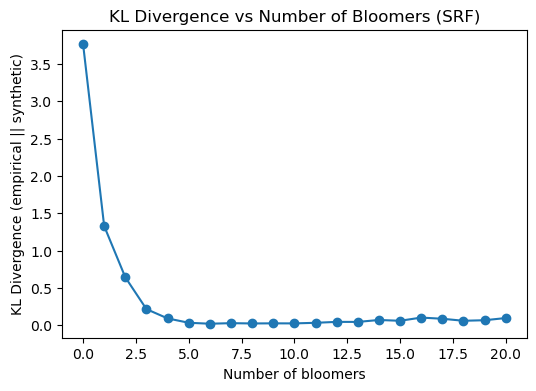

In [52]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(numbers_of_bloomers, kl_divergences, marker='o')
ax.set_xlabel('Number of bloomers')
ax.set_ylabel('KL Divergence (empirical || synthetic)')
ax.set_title('KL Divergence vs Number of Bloomers (SRF)')

# Greedy search

In [68]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import entropy

# ---------------------------
# PARAMETRI
# ---------------------------
ABUNDANCE_TSH = 1
ALPHA_ZIPF = 0.5
N_SYN_REP = 10
EPS = 1e-12
IMPROVING_FACTOR = 1.05  # greedy

# ---------------------------
# UTILS
# ---------------------------
def parse_station_depth(col):
    station = int(col.split('_')[0])
    depth = col.split('_')[-1]
    return station, depth

def simulate_bulk_sum_zipf_trunc(S, nrep, alpha):
    """ media_repliche [ somma_{s=1..S} Zipf_troncata(max_val=s) ] """
    if S <= 0:
        return 0.0
    acc = 0.0
    for _ in range(nrep):
        total = 0
        for s in range(1, int(S) + 1):
            total += zipfrand(Zipf(alpha=alpha), max_val=s)
        acc += total
    return acc / nrep

def simulate_K_from_S(S_array, nrep, alpha):
    """K_synth per ciascun S: K = S / sqrt(N_syn); N_syn dalla somma zipf troncata."""
    out = []
    for S in S_array:
        if S <= 0:
            continue
        N_syn = simulate_bulk_sum_zipf_trunc(int(S), nrep, alpha)
        if N_syn > 0:
            out.append(S / np.sqrt(N_syn))
    return np.array(out, dtype=float)

# ---------------------------
# METRICA (solo SRF, solo bulk = matrice corrente)
# ---------------------------
def compute_K_and_S_SRF_bulk(Abundances, abundance_thsh=ABUNDANCE_TSH):
    """
    Su colonne SRF:
      - filtra per soglia (> abundance_thsh)
      - richness = # specie con abbondanza > soglia
      - biomass  = somma abbondanze
      - K = richness / sqrt(biomass)
    Ritorna K_emp (array) e S (richness) con stesse stazioni valide.
    """
    cols_srf = [c for c in Abundances.columns if parse_station_depth(c)[1] == 'SRF']
    if not cols_srf:
        return np.array([]), np.array([])

    # Applica soglia
    A = Abundances.loc[:, cols_srf].copy()
    A = A.where(A > abundance_thsh, other=0)

    # Richness (conteggio specie > soglia) e Biomass (somma)
    richness = (A > 0).sum(axis=0).astype(int)
    biomass  = A.sum(axis=0).astype(float)

    valid = (richness > 0) & (biomass > 0)
    if valid.sum() < 2:
        return np.array([]), np.array([])

    K_emp = (richness[valid] / np.sqrt(biomass[valid])).values.astype(float)
    S_arr = richness[valid].values.astype(int)
    return K_emp, S_arr

def KL_empirical_vs_synthetic(Abundances,
                              abundance_thsh=ABUNDANCE_TSH,
                              alpha_zipf=ALPHA_ZIPF,
                              n_syn_rep=N_SYN_REP):
    """
    KL(emp || syn) tra distribuzioni di |log10(K_i) - log10(K_j)| (SRF).
    """
    K_emp, S_arr = compute_K_and_S_SRF_bulk(Abundances, abundance_thsh)
    if len(K_emp) < 2:
        return np.nan

    # Empirical pairwise |Δ log10 K|
    logK_emp = np.log10(K_emp)
    emp_diffs = pdist(logK_emp.reshape(-1, 1), metric='cityblock')

    # Synthetic da S (richness corrente, nessun “bloomers”)
    K_syn = simulate_K_from_S(S_arr, n_syn_rep, alpha_zipf)
    if len(K_syn) < 2:
        return np.nan

    logK_syn = np.log10(K_syn)
    syn_diffs = pdist(logK_syn.reshape(-1, 1), metric='cityblock')

    # Istogrammi condivisi
    bins = np.histogram_bin_edges(np.concatenate([emp_diffs, syn_diffs]), bins='auto')
    emp_hist, _ = np.histogram(emp_diffs, bins=bins, density=True)
    syn_hist, _ = np.histogram(syn_diffs, bins=bins, density=True)

    emp_hist += EPS
    syn_hist += EPS
    return float(entropy(emp_hist, syn_hist))

# ---------------------------
# GREEDY: rimozione globale di una specie alla volta
# ---------------------------
def greedy_global_remove_to_minimize_KL(Abundances,
                                        max_remove=50,
                                        candidate_species=None,
                                        abundance_thsh=ABUNDANCE_TSH,
                                        alpha_zipf=ALPHA_ZIPF,
                                        n_syn_rep=N_SYN_REP,
                                        improving_factor=IMPROVING_FACTOR,
                                        prefilter_top_k=300):
    """
    A ogni passo rimuove la specie (riga) che riduce di più la KL.
    Si ferma se non migliora o raggiunge max_remove.

    Ritorna: Abundances_reduced, history (lista dict: specie, KL_before, KL_after, delta)
    """
    A = Abundances.copy()
    history = []

    # Candidati: per velocità, di default le specie più abbondanti globalmente
    if candidate_species is None:
        totals = A.sum(axis=1).sort_values(ascending=False)
        if prefilter_top_k and prefilter_top_k < len(totals):
            candidate_species = list(totals.head(prefilter_top_k).index)
        else:
            candidate_species = list(totals.index)
    else:
        candidate_species = [s for s in candidate_species if s in A.index]

    kl_curr = KL_empirical_vs_synthetic(A, abundance_thsh, alpha_zipf, n_syn_rep)

    for step in range(max_remove):
        print(f"Step {step+1}, current KL: {kl_curr:.6f}, candidates left: {len(candidate_species)}")
        best_sp, best_kl = None, kl_curr
        improved = False

        # valuta rimozione di ciascun candidato
        for sp in candidate_species:
            A_try = A.drop(index=sp)
            kl_try = KL_empirical_vs_synthetic(A_try, abundance_thsh, alpha_zipf, n_syn_rep)
            if np.isnan(kl_try):
                continue
            if kl_try < best_kl*improving_factor:
                best_sp, best_kl = sp, kl_try
                improved = True

        if not improved:
            break

        # applica rimozione migliore
        A = A.drop(index=best_sp)
        history.append({
            "step": step + 1,
            "species_removed": best_sp,
            "KL_before": kl_curr,
            "KL_after": best_kl,
            "delta": kl_curr - best_kl
        })
        kl_curr = best_kl
        candidate_species.remove(best_sp)

    return A, history

In [69]:
A_reduced, hist = greedy_global_remove_to_minimize_KL(
    SRF_Abundances,
    max_remove=30,           # quante specie al massimo vuoi togliere
    candidate_species=None,  # usa tutte le specie come candidati
    abundance_thsh=ABUNDANCE_TSH,
    alpha_zipf=ALPHA_ZIPF,
    n_syn_rep=N_SYN_REP,
    prefilter_top_k=50,     # valuta solo le specie più abbondanti globalmente (velocizza molto)
)

Step 1, current KL: 3.167405, candidates left: 50
Step 2, current KL: 2.933684, candidates left: 49
Step 3, current KL: 2.571712, candidates left: 48
Step 4, current KL: 1.961466, candidates left: 47
Step 5, current KL: 1.718275, candidates left: 46


In [70]:
progress = pd.DataFrame(hist)

## parallel version

In [87]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import entropy
from joblib import Parallel, delayed

# ---------------------------
# PARAMETRI (default)
# ---------------------------
ABUNDANCE_TSH = 1
ALPHA_ZIPF = 0.5
N_SYN_REP = 10
EPS = 1e-12
IMPROVING_FACTOR = 1.  # accetta miglioramenti >= 5%
N_JOBS = -1              # usa tutti i core

# ---------------------------
# UTILS
# ---------------------------
def parse_station_depth(col):
    station = int(col.split('_')[0])
    depth = col.split('_')[-1]
    return station, depth

def simulate_bulk_sum_zipf_trunc(S, nrep, alpha):
    """
    media_repliche [ somma_{s=1..S} Zipf_troncata(max_val=s) ].
    Richiede zipfrand(Zipf(alpha), max_val=s).
    """
    if S <= 0:
        return 0.0
    acc = 0.0
    for _ in range(nrep):
        total = 0
        for s in range(1, int(S) + 1):
            total += zipfrand(Zipf(alpha=alpha), max_val=s)
        acc += total
    return acc / nrep

def simulate_K_from_S(S_array, nrep, alpha):
    """K_synth per ciascun S: K = S / sqrt(N_syn); N_syn dalla somma zipf troncata."""
    out = []
    for S in S_array:
        if S <= 0:
            continue
        N_syn = simulate_bulk_sum_zipf_trunc(int(S), nrep, alpha)
        if N_syn > 0:
            out.append(S / np.sqrt(N_syn))
    return np.array(out, dtype=float)

# ---------------------------
# METRICA (solo SRF, sul bulk corrente)
# ---------------------------
def compute_K_and_S_SRF_bulk(Abundances, abundance_thsh=ABUNDANCE_TSH):
    """
    Bulk = matrice corrente (dopo eventuali rimozioni).
    Ritorna K_emp (array) e S (richness) per le stazioni valide.
    """
    A = Abundances.where(Abundances >= abundance_thsh, other=0)

    richness = (A > 0).sum(axis=0).astype(int)
    biomass  = A.sum(axis=0).astype(float)

    valid = (richness > 0) & (biomass > 0)
    if valid.sum() < 2:
        return np.array([]), np.array([])

    K_emp = (richness[valid] / np.sqrt(biomass[valid])).values.astype(float)
    S_arr = richness[valid].values.astype(int)
    return K_emp, S_arr

def KL_empirical_vs_synthetic(Abundances,
                              abundance_thsh=ABUNDANCE_TSH,
                              alpha_zipf=ALPHA_ZIPF,
                              n_syn_rep=N_SYN_REP):
    """
    KL(emp || syn) tra distribuzioni di |log10(K_i) - log10(K_j)| (SRF).
    """
    K_emp, S_arr = compute_K_and_S_SRF_bulk(Abundances, abundance_thsh)
    if len(K_emp) < 2:
        return np.nan

    logK_emp = np.log10(K_emp)
    emp_diffs = pdist(logK_emp.reshape(-1, 1), metric='cityblock')

    K_syn = simulate_K_from_S(S_arr, n_syn_rep, alpha_zipf)
    if len(K_syn) < 2:
        return np.nan

    logK_syn = np.log10(K_syn)
    syn_diffs = pdist(logK_syn.reshape(-1, 1), metric='cityblock')

    bins = np.histogram_bin_edges(np.concatenate([emp_diffs, syn_diffs]), bins='auto')
    emp_hist, _ = np.histogram(emp_diffs, bins=bins, density=True)
    syn_hist, _ = np.histogram(syn_diffs, bins=bins, density=True)

    emp_hist += EPS
    syn_hist += EPS
    return float(entropy(emp_hist, syn_hist))

# ---------------------------
# PARALLEL (joblib/loky)
# ---------------------------
def _eval_candidate_joblib(sp, A, abundance_thsh, alpha_zipf, n_syn_rep):
    A_try = A.drop(index=sp)
    kl_try = KL_empirical_vs_synthetic(A_try, abundance_thsh, alpha_zipf, n_syn_rep)
    return sp, kl_try


def parallel_best_removal_joblib(A, candidate_species, kl_curr, improving_factor,
                                 abundance_thsh, alpha_zipf, n_syn_rep,
                                 n_jobs=N_JOBS, verbose=0):
    results = Parallel(n_jobs=n_jobs, backend="loky", verbose=verbose)(
        delayed(_eval_candidate_joblib)(sp, A, abundance_thsh, alpha_zipf, n_syn_rep)
        for sp in candidate_species
    )

    # migliore assoluto (anche se non "improva")
    min_sp, min_kl = None, inf

    # migliore che soddisfa l'improving_factor
    best_sp, best_kl = None, inf

    for sp, kl_try in results:
        if np.isnan(kl_try):
            continue

        # traccia il minimo assoluto
        if kl_try < min_kl:
            min_sp, min_kl = sp, kl_try

        # traccia il migliore che rispetta l'improving_factor
        if kl_try < kl_curr * improving_factor and kl_try < best_kl:
            best_sp, best_kl = sp, kl_try

    # se non c'è alcun candidato valido
    if min_sp is None:
        return None, kl_curr, False

    # se nessuno rispetta improving_factor, prendi il minimo assoluto
    if best_sp is None:
        return min_sp, min_kl, False

    # altrimenti prendi quello che migliora (ed è già il migliore tra quelli che migliorano)
    return best_sp, best_kl, True

# ---------------------------
# GREEDY globale: rimuove una specie alla volta
# ---------------------------
def greedy_global_remove_to_minimize_KL(Abundances,
                                        max_remove=50,
                                        candidate_species=None,
                                        abundance_thsh=ABUNDANCE_TSH,
                                        alpha_zipf=ALPHA_ZIPF,
                                        n_syn_rep=N_SYN_REP,
                                        improving_factor=IMPROVING_FACTOR,
                                        prefilter_top_k=300,
                                        parallel=True,
                                        n_jobs=N_JOBS,
                                        verbose=True):
    """
    A ogni passo rimuove la specie (riga) che riduce la KL di almeno 'improving_factor'.
    Bulk = matrice corrente; SRF-only per il calcolo di K; sintetico dipende solo da S.
    Ritorna (Abundances_reduced, history).
    """
    A = Abundances.copy()
    history = []

    # Preselezione candidati (p.es. specie più abbondanti globalmente)
    if candidate_species is None:
        totals = A.sum(axis=1).sort_values(ascending=False)
        if prefilter_top_k and prefilter_top_k < len(totals):
            candidate_species = list(totals.head(prefilter_top_k).index)
        else:
            candidate_species = list(totals.index)
    else:
        candidate_species = [s for s in candidate_species if s in A.index]

    kl_curr = KL_empirical_vs_synthetic(A, abundance_thsh, alpha_zipf, n_syn_rep)

    for step in range(max_remove):
        if verbose:
            print(f"[Step {step+1}] KL={kl_curr:.6f} | candidates={len(candidate_species)}")

        if parallel:
            best_sp, best_kl, improved = parallel_best_removal_joblib(
                A, candidate_species, kl_curr, improving_factor,
                abundance_thsh, alpha_zipf, n_syn_rep,
                n_jobs=n_jobs, verbose=0
            )
        else:
            best_sp, best_kl, improved = None, kl_curr, False
            for sp in candidate_species:
                A_try = A.drop(index=sp)
                kl_try = KL_empirical_vs_synthetic(A_try, abundance_thsh, alpha_zipf, n_syn_rep)
                if not np.isnan(kl_try) and kl_try < best_kl:
                    best_sp, best_kl, improved = sp, kl_try, True

        if not improved or best_sp is None:
            if verbose:
                print("No further improvement — stopping.")
            break

        # Applica rimozione migliore
        A = A.drop(index=best_sp)
        history.append({
            "step": step + 1,
            "species_removed": best_sp,
            "KL_before": kl_curr,
            "KL_after": best_kl,
            "delta": kl_curr - best_kl
        })
        kl_curr = best_kl
        candidate_species.remove(best_sp)

    return A, history

# ---------------------------
# ESEMPIO USO
# ---------------------------
# A_reduced, hist = greedy_global_remove_to_minimize_KL(
#     Abundances,
#     max_remove=30,
#     improving_factor=1.02,
#     prefilter_top_k=300,
#     parallel=True,
#     n_jobs=-1,   # tutti i core
#     verbose=True
# )
# pd.DataFrame(hist)

In [ ]:
A_reduced, hist = greedy_global_remove_to_minimize_KL(
    SRF_Abundances,
    n_syn_rep=20,
    max_remove=14,
    improving_factor=1.,
    prefilter_top_k=50,
    parallel=True,
    n_jobs=-1,   # tutti i core
    verbose=True
)

[Step 1] KL=4.351109 | candidates=50
[Step 2] KL=3.690725 | candidates=49
[Step 3] KL=3.316364 | candidates=48
[Step 4] KL=3.003929 | candidates=47
[Step 5] KL=2.793613 | candidates=46
[Step 6] KL=2.698780 | candidates=45
[Step 7] KL=2.630171 | candidates=44
[Step 8] KL=2.244570 | candidates=43
[Step 9] KL=2.088884 | candidates=42
[Step 10] KL=1.758640 | candidates=41


In [ ]:
pd.DataFrame(hist)

,step,species_removed,KL_before,KL_after,delta
0,1,d9fba6377f54ac59eb080a698fb80b5a,4.429719,3.806693,0.623026
1,2,30191c0570b3035d38a5bc7cc8738a04,3.806693,3.397437,0.409256
2,3,91a0bf62bf8dc9a63294b12e76618a1f,3.397437,2.670567,0.726870
3,4,d48b807afa0c0eebbac0ec98aa538cf7,2.670567,2.458168,0.212400
4,5,f75ad4c6d7d0dc51a0a6c2f54ca770da,2.458168,2.224912,0.233255
